# Hierarchical Bayesian modeling

Inspired from: https://bambinos.github.io/bambi/main/notebooks/radon_example.html

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from functools import partial
from itertools import cycle
import numpy as np

import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import blackjax

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

plt.rcParams['figure.dpi'] = 100
color = cycle(['r', 'g', 'b', 'k'])

## Load and preprocess data

In [2]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Get city data
city_df = pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/cty.dat")
city_df.head(2)

# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
df = radon_df[radon_df.state == "MN"].copy()
city_mn_df = city_df[city_df.st == "MN"].copy()

# Compute fips
df["fips"] = 1_000 * df.stfips + df.cntyfips
city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# Merge data
df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Compute log of Uranium
df["log_u"] = np.log(df["Uppm"])

# Let's map floor. 0 -> Basement and 1 -> Floor
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Sort values by floor
df = df.sort_values(by="floor")

# Reset index
df = df.reset_index(drop=True)
df["log_activity"] = np.log(0.1 + df["activity"])

## Distribution of radon

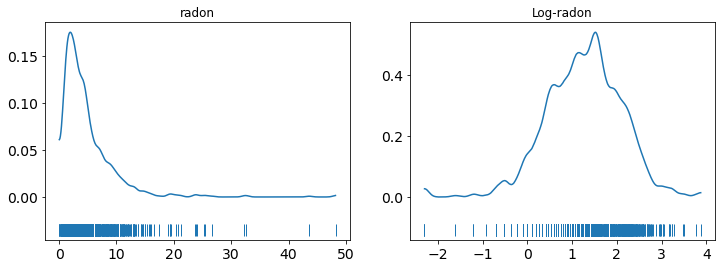

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title("radon")
ax[1].set_title("Log-radon")

az.plot_dist(df["activity"], rug=True, ax=ax[0]);
az.plot_dist(df["log_activity"], rug=True, ax=ax[1]);

## Floor wise distribution

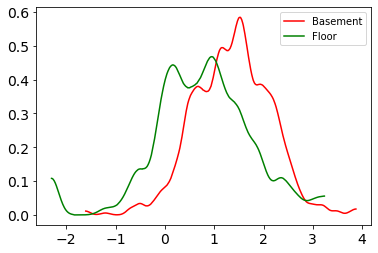

In [4]:
colors = ['b', 'r']
for i, floor in enumerate(df["floor"].unique()):
    az.plot_dist(df[df.floor==floor]["log_activity"], label=floor, color=next(color))

## Number of observations per county

In [5]:
df['county'].unique().size

85

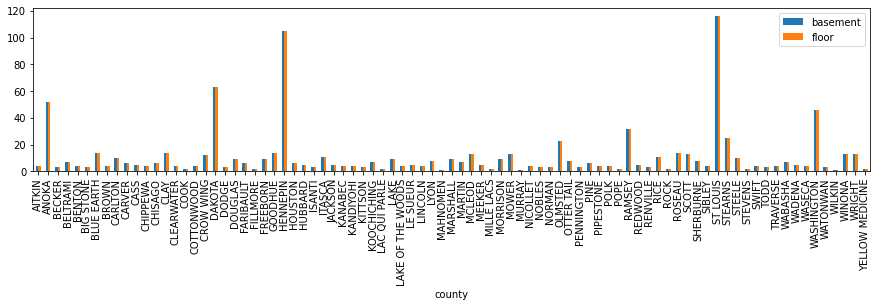

In [6]:
fig,ax = plt.subplots(figsize=(15,3))
df.groupby('county').agg({"basement": "count", "floor": "count"}).plot(kind='bar', ax=ax);

## Completely pooled model (common prediction for all counties)

### Model
* ### $LogRadon = \beta_j + \epsilon, j \in \{\text{floor, basement}\}$

### Prior
* ### $\beta_j \sim \mathcal{N}(0, 10), j \in \{\text{floor, basement}\}$

### Likelihood
* ### $\epsilon \sim \mathcal{N}(0, \sigma)$
* ### $\sigma \sim Exp(1)$

### Parameters
* ### $\beta_{floor}, \beta_{basement}, \sigma$

### Prepare data

In [7]:
y_floor = jnp.asarray(df[df.floor == "Floor"].log_activity.values)
y_basement = jnp.asarray(df[df.floor == "Basement"].log_activity.values)
y_floor.shape, y_basement.shape

((153,), (766,))

### Define unnormalized log probability or log joint

In [8]:
def log_joint(params, y_floor, y_basement):
    # Distributions
    beta_dist = tfd.Normal(0.0, 10.0)
    noise_dist = tfd.Normal(0.0, params["noise_std"])
    noise_std_dist = tfd.Exponential(rate=1.0)
    
    # Priors
    log_prior_floor = beta_dist.log_prob(params["beta_floor"])
    log_prior_basement = beta_dist.log_prob(params["beta_basement"])
    log_prior_noise_std = noise_std_dist.log_prob(params["noise_std"])
    
    # Likelihood
    noise = jnp.concatenate([y_floor - params["beta_floor"], y_basement-params["beta_basement"]])
    log_likelihood = noise_dist.log_prob(noise).sum()
    
    return log_likelihood + log_prior_floor + log_prior_basement + log_prior_noise_std

### BlackJAX NUTS MCMC

In [9]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [10]:
initial_position = {"beta_floor": 1.0, 
                    "beta_basement": 1.0, 
                    "noise_std": 0.1}
log_joint_fn = partial(log_joint, y_basement=y_basement, y_floor=y_floor)

In [11]:
log_joint_fn(initial_position)

DeviceArray(-32771.07, dtype=float32)

In [12]:
# define nuts
inv_mass_matrix = np.array([0.5, 0.5, 0.5])
step_size = 1e-3
nuts = blackjax.nuts(log_joint_fn, step_size, inv_mass_matrix)

# warmup
warmup = blackjax.window_adaptation(blackjax.nuts, log_joint_fn, 1000)
rng_key = jax.random.PRNGKey(0)
initial_state, kernel, _ = warmup.run(rng_key, initial_position)

# run mcmc
states = inference_loop(rng_key, nuts.step, initial_state, 10000)

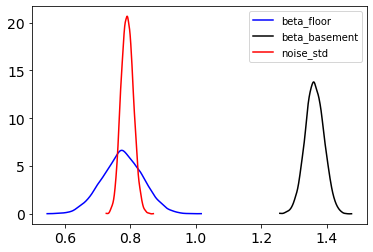

In [13]:
for key in initial_position:
    az.plot_dist(states.position[key], label=key, color=next(color));

## No pooling

### Model
* ### $LogRadon = \beta_{jk} + \epsilon, j \in \{\text{floor, basement}\}, k \in \text{counties}$

### Prior
* ### $\beta_{jk} \sim \mathcal{N}(0, 10), j \in \{\text{floor, basement}\}, k \in \text{counties}$

### Likelihood
* ### $\epsilon \sim \mathcal{N}(0, \sigma)$
* ### $\sigma \sim Exp(1)$

### Parameters
* ### $\beta_{jk}, \sigma$

### Prepare data

In [14]:
y_floor = df[df.floor == "Floor"].groupby('county').agg({"log_activity": lambda x:jnp.asarray(x)}).to_dict()['log_activity']
y_basement = df[df.floor == "Basement"].groupby('county').agg({"log_activity": lambda x: jnp.asarray(x)}).to_dict()['log_activity']
y_floor

{'AITKIN': DeviceArray([0.8329091], dtype=float32),
 'ANOKA': DeviceArray([ 0.18232156,  0.64185387, -1.2039728 ], dtype=float32),
 'BECKER': DeviceArray([0.26236427, 1.5260563 ], dtype=float32),
 'BELTRAMI': DeviceArray([ 1.5040774,  1.5475625, -0.6931472,  0.8329091], dtype=float32),
 'BENTON': DeviceArray([1.0986123], dtype=float32),
 'BLUE EARTH': DeviceArray([1.7749523, 2.6672282], dtype=float32),
 'BROWN': DeviceArray([0.95551145, 1.410987  ], dtype=float32),
 'CARLTON': DeviceArray([1.7404661], dtype=float32),
 'CARVER': DeviceArray([ 1.5686159,  2.6946273, -2.3025851], dtype=float32),
 'CLAY': DeviceArray([1.9459101 , 0.95551145, 1.2809339 , 0.        ], dtype=float32),
 'CLEARWATER': DeviceArray([1.5892352, 0.       ], dtype=float32),
 'COTTONWOOD': DeviceArray([ 0.95551145, -2.3025851 ,  2.4159138 ], dtype=float32),
 'CROW WING': DeviceArray([1.9169226 , 0.95551145, 0.09531018], dtype=float32),
 'DAKOTA': DeviceArray([-0.10536052,  0.5877867 ,  1.0647107 ,  0.4054651 ], dtype

In [15]:
def log_joint(params, y_floor, y_basement):
    # Distributions
    beta_dist = tfd.Normal(0.0, 10.0)
    noise_dist = tfd.Normal(0.0, params["noise_std"])
    noise_std_dist = tfd.Exponential(rate=1.0)
    
    # Priors
    flat_beta_floor = ravel_pytree(params["beta_floor"])[0]
    flat_beta_basement = ravel_pytree(params["beta_basement"])[0]
    
    log_prior_floor = beta_dist.log_prob(flat_beta_floor).sum()
    log_prior_basement = beta_dist.log_prob(flat_beta_basement).sum()
    log_prior_noise_std = noise_std_dist.log_prob(params["noise_std"])
    
    # Likelihood
    noise_floor = jax.tree_map(lambda x, m: x - m, y_floor, params["beta_floor"])
    noise_basement = jax.tree_map(lambda x, m: x - m, y_basement, params["beta_basement"])

    noise = jnp.concatenate([ravel_pytree(noise_floor)[0], ravel_pytree(noise_basement)[0]])
    
    log_likelihood = noise_dist.log_prob(noise).sum()
    
    return log_likelihood + log_prior_floor + log_prior_basement + log_prior_noise_std

In [16]:
rng_key = jax.random.PRNGKey(0)
initial_position = {"beta_floor": jax.tree_util.tree_map(lambda x: 1.0, y_floor), 
                    "beta_basement": jax.tree_util.tree_map(lambda x: 1.0, y_basement), 
                    "noise_std": jnp.asarray(0.1)}

params_size = ravel_pytree(initial_position)[0].size
log_joint_fn = partial(log_joint, y_basement=y_basement, y_floor=y_floor)

In [17]:
log_joint_fn(initial_position)

DeviceArray(-33232.46, dtype=float32)

In [18]:
# define nuts
inv_mass_matrix = jnp.array(0.5).repeat(params_size)
step_size = 1e-3
nuts = blackjax.nuts(log_joint_fn, step_size, inv_mass_matrix)

# warmup
warmup = blackjax.window_adaptation(blackjax.nuts, log_joint_fn, 1000, progress_bar=True)
rng_key = jax.random.PRNGKey(0)
initial_state, kernel, _ = warmup.run(rng_key, initial_position)

print("Running MCMC")

# run mcmc
states = inference_loop(rng_key, nuts.step, initial_state, 1000)

Running window adaptation



Running MCMC


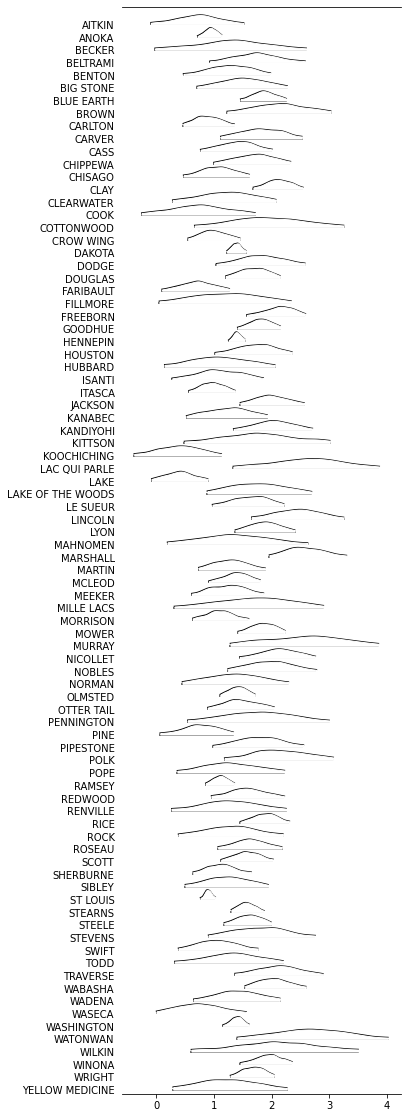

In [19]:
az.plot_forest(states.position['beta_basement'],
               kind='ridgeplot',
               combined=True,
               ridgeplot_overlap=3,
               colors='white',
               figsize=(5, 20));

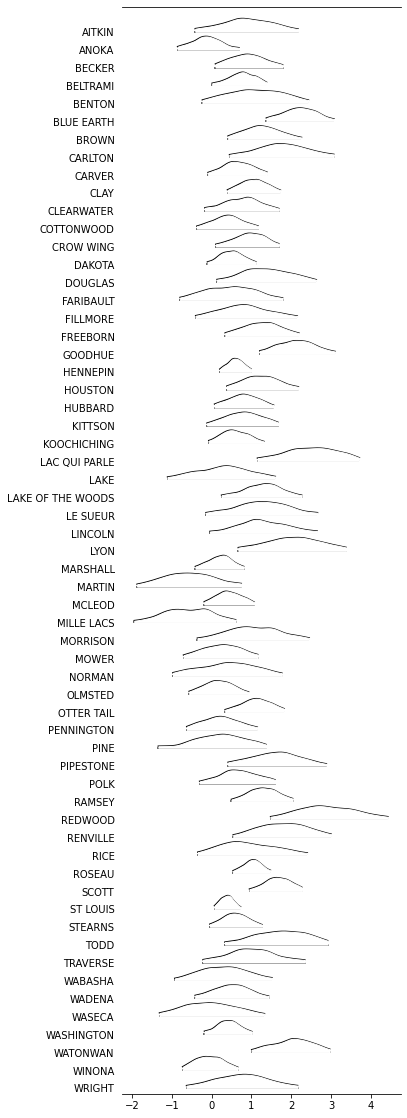

In [20]:
az.plot_forest(states.position['beta_floor'],
               kind='ridgeplot',
               combined=True,
               ridgeplot_overlap=3,
               colors='white',
               figsize=(5, 20));

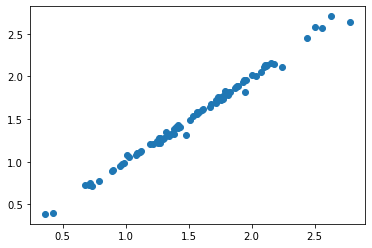

In [21]:
predicted_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, states.position['beta_basement']))[0]
true_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, y_basement))[0]

plt.scatter(true_means, predicted_means);

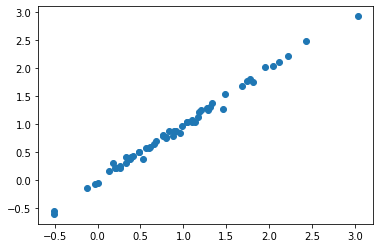

In [22]:
predicted_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, states.position['beta_floor']))[0]
true_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, y_floor))[0]

plt.scatter(true_means, predicted_means);

### Partially pooled model

### Model
* ### $LogRadon = \beta_{jk} + \epsilon, j \in \{\text{floor, basement}\}, k \in \text{counties}$

### Prior
* ### $\beta_{jk} \sim \mathcal{N}(\alpha_j, \sigma_j), j \in \{\text{floor, basement}\}, k \in \text{counties}$
* ### $\alpha_j \sim \mathcal{N}(0, 10)$
* ### $\sigma_j \sim Exp(1)$

### Likelihood
* ### $\epsilon \sim \mathcal{N}(0, \sigma)$
* ### $\sigma_n \sim Exp(1)$

### Parameters
* ### $\beta_{jk}, \sigma_j, \sigma_n, \alpha_j$

In [23]:
def log_joint(params, y_floor, y_basement):
    # Distributions
    sigma_dist = tfd.Exponential(rate=1.0)
    alpha_dist = tfd.Normal(0, 10)
    beta_floor_dist = tfd.Normal(params["alpha_floor"], params["sigma_floor"])
    beta_basement_dist = tfd.Normal(params["alpha_basement"], params["sigma_basement"])
    noise_dist = tfd.Normal(0.0, params["noise_std"])
    noise_std_dist = tfd.Exponential(rate=1.0)
    
    # Priors
    flat_beta_floor = ravel_pytree(params["beta_floor"])[0]
    flat_beta_basement = ravel_pytree(params["beta_basement"])[0]
    
    log_prior_alpha = alpha_dist.log_prob(params["alpha_basement"]) + alpha_dist.log_prob(params["alpha_floor"])
    log_prior_sigma = sigma_dist.log_prob(params["sigma_basement"]) + sigma_dist.log_prob(params["sigma_floor"])
    log_prior_floor = beta_floor_dist.log_prob(flat_beta_floor).sum()
    log_prior_basement = beta_basement_dist.log_prob(flat_beta_basement).sum()
    log_prior_noise_std = noise_std_dist.log_prob(params["noise_std"])
    
    # Likelihood
    noise_floor = jax.tree_map(lambda x, m: x - m, y_floor, params["beta_floor"])
    noise_basement = jax.tree_map(lambda x, m: x - m, y_basement, params["beta_basement"])

    noise = jnp.concatenate([ravel_pytree(noise_floor)[0], ravel_pytree(noise_basement)[0]])
    
    log_likelihood = noise_dist.log_prob(noise).sum()
    
    return log_likelihood + log_prior_floor + log_prior_basement + log_prior_noise_std + log_prior_sigma + log_prior_alpha

In [24]:
rng_key = jax.random.PRNGKey(0)
initial_position = {"beta_floor": jax.tree_util.tree_map(lambda x: 1.0, y_floor), 
                    "beta_basement": jax.tree_util.tree_map(lambda x: 1.0, y_basement), 
                    "noise_std": jnp.asarray(0.1),
                    "sigma_floor": jnp.asarray(0.1),
                    "sigma_basement": jnp.asarray(0.1),
                    "alpha_floor": jnp.asarray(0.1),
                    "alpha_basement": jnp.asarray(0.2),
                   }

params_size = ravel_pytree(initial_position)[0].size
log_joint_fn = partial(log_joint, y_basement=y_basement, y_floor=y_floor)

In [25]:
log_joint_fn(initial_position)

DeviceArray(-37720.63, dtype=float32)

In [26]:
# define nuts
inv_mass_matrix = jnp.array(0.5).repeat(params_size)
step_size = 1e-3
nuts = blackjax.nuts(log_joint_fn, step_size, inv_mass_matrix)

# warmup
warmup = blackjax.window_adaptation(blackjax.nuts, log_joint_fn, 1000, progress_bar=True)
rng_key = jax.random.PRNGKey(0)
initial_state, kernel, _ = warmup.run(rng_key, initial_position)

print("Running MCMC")

# run mcmc
states = inference_loop(rng_key, nuts.step, initial_state, 1000)

Running window adaptation



Running MCMC


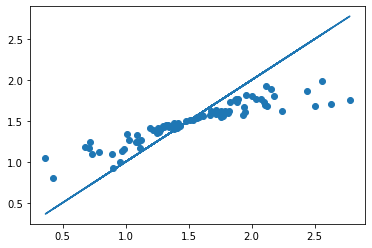

In [30]:
predicted_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, states.position['beta_basement']))[0]
true_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, y_basement))[0]

plt.scatter(true_means, predicted_means);
plt.plot(true_means, true_means);

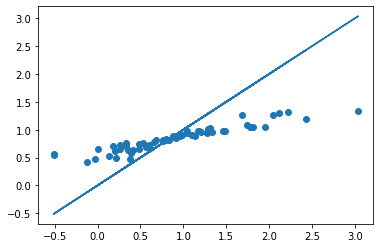

In [31]:
predicted_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, states.position['beta_floor']))[0]
true_means = ravel_pytree(jax.tree_util.tree_map(jnp.mean, y_floor))[0]

plt.scatter(true_means, predicted_means);
plt.plot(true_means, true_means);